<a href="https://colab.research.google.com/github/tnc-br/ddf-isoscapes/blob/new_kl/dnn/weird_result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational model

Find the mean/variance of O18 ratios (as well as N15 and C13 in the future) at a particular lat/lon across Brazil. At the bottom of the colab, train and evaluate 4 different versions of the model with different data partitioning strategies.

In [43]:
from collections import defaultdict
import math
import numpy as np
import pandas as pd
import datetime
import os
from typing import List, Tuple, Dict
from dataclasses import dataclass
from joblib import dump


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from matplotlib import pyplot as plt
from tensorflow.python.ops import math_ops
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.compose import ColumnTransformer

#@title Debugging
# See https://zohaib.me/debugging-in-google-collab-notebook/ for tips,
# as well as docs for pdb and ipdb.
DEBUG = False #@param {type:"boolean"}
USE_LOCAL_DRIVE = True #@param {type:"boolean"}
LOCAL_DIR = "/usr/local/google/home/ruru/Downloads/amazon_sample_data-20230712T203059Z-001" #@param
GDRIVE_DIR = "MyDrive/amazon_rainforest_files/" #@param
FP_ROOT = LOCAL_DIR

MODEL_SAVE_LOCATION = "/usr/local/google/home/ruru/Downloads/model_builds" #@param

def get_model_save_location(filename) -> str:
  root = '' if USE_LOCAL_DRIVE else '/content/drive'
  return os.path.join(root, MODEL_SAVE_LOCATION, filename)

# Access data stored on Google Drive if not reading data locally.
if not USE_LOCAL_DRIVE:
  from google.colab import drive
  drive.mount('/content/drive')
  global FP_ROOT
  FP_ROOT = os.path.join('/content/drive', GDRIVE_DIR)

if DEBUG:
    %pip install -Uqq ipdb
    import ipdb
    %pdb on

# Data preparation


In [34]:
def load_dataset(path: str, columns_to_keep: List[str]):
  df = pd.read_csv(path, encoding="ISO-8859-1", sep=',')
  df = df[df['d18O_cel_variance'].notna()]
  X = df

  X['krig_mean_residual'] = X['ordinary_kriging_linear_d18O_predicted_mean'] - X['d18O_cel_mean']
  X['krig_variance_residual'] = X['ordinary_kriging_linear_d18O_predicted_variance'] - X['d18O_cel_variance']

  columns_to_keep = columns_to_keep + ['krig_mean_residual', 'krig_variance_residual']
  X = X.drop(df.columns.difference(columns_to_keep), axis=1)

  Y = df[["d18O_cel_mean", "d18O_cel_variance"]]
  print(X)
  return X, Y

Standardization

In [42]:
@dataclass
class FeaturesToLabels:
  def __init__(self, X: pd.DataFrame, Y: pd.DataFrame):
    self.X = X
    self.Y = Y

  def as_tuple(self):
    return (self.X, self.Y)


def create_feature_scaler(X: pd.DataFrame, columns_to_normalize, columns_to_standardize) -> ColumnTransformer:
  feature_scaler = ColumnTransformer(
      [('krig_mean_residual_scaler', StandardScaler(), ['krig_mean_residual']),
       ('krig_variance_residual_scaler', StandardScaler(), ['krig_variance_residual'])] +
      [(column+'_normalizer', Normalizer(), [column]) for column in columns_to_normalize] +
      [(column+'_standardizer', StandardScaler(), [column]) for column in columns_to_standardize],
      remainder='passthrough')
  feature_scaler.fit(X)
  print(feature_scaler)
  return feature_scaler

def create_label_scaler(Y: pd.DataFrame) -> ColumnTransformer:
  label_scaler = ColumnTransformer([
      ('mean_std_scaler', StandardScaler(), ['d18O_cel_mean']),
      ('var_minmax_scaler', MinMaxScaler(), ['d18O_cel_variance'])],
      remainder='passthrough')
  label_scaler.fit(Y)
  return label_scaler

def scale(X: pd.DataFrame, Y: pd.DataFrame, feature_scaler, label_scaler):
  # transform() outputs numpy arrays :(  need to convert back to DataFrame.
  X_standardized = pd.DataFrame(feature_scaler.transform(X),
                        index=X.index, columns=X.columns)
  return FeaturesToLabels(X_standardized, Y)

In [15]:
# Just a class organization, holds each scaled dataset and the scaler used.
# Useful for unscaling predictions.
@dataclass
class ScaledPartitions():
  def __init__(self,
               feature_scaler: ColumnTransformer,
               label_scaler: ColumnTransformer,
               train: FeaturesToLabels, val: FeaturesToLabels,
               test: FeaturesToLabels):
    self.feature_scaler = feature_scaler
    self.label_scaler = label_scaler
    self.train = train
    self.val = val
    self.test = test


def load_and_scale(config: Dict,
                   columns_to_normalize: List[str],
                   columns_to_standardize: List[str]) -> ScaledPartitions:
  columns_to_keep = columns_to_normalize + columns_to_standardize
  X_train, Y_train = load_dataset(config['TRAIN'], columns_to_keep)
  X_val, Y_val = load_dataset(config['VALIDATION'], columns_to_keep)
  X_test, Y_test = load_dataset(config['TEST'], columns_to_keep)

  feature_scaler = create_feature_scaler(X_train, columns_to_normalize, columns_to_standardize)
  label_scaler = create_label_scaler(Y_train)
  train = scale(X_train, Y_train, feature_scaler, label_scaler)
  val = scale(X_val, Y_val, feature_scaler, label_scaler)
  test = scale(X_test, Y_test, feature_scaler, label_scaler)
  return ScaledPartitions(feature_scaler, label_scaler, train, val, test)


# Model Definition



The KL Loss function:

In [8]:
def sample_normal_distribution(
    mean: tf.Tensor,
    stdev: tf.Tensor,
    n: int) -> tf.Tensor:
    '''
    Given a batch of normal distributions described by a mean and stdev in
    a tf.Tensor, sample n elements from each distribution and return the mean
    and standard deviation per sample.
    '''
    batch_size = tf.shape(mean)[0]

    # Output tensor is (n, batch_size, 1)
    sample_values = tfp.distributions.Normal(
        loc=mean,
        scale=stdev).sample(
            sample_shape=n)
    # Reshaped tensor will be (batch_size, n)
    sample_values = tf.transpose(sample_values)
    # Get the mean per sample in the batch.
    sample_mean = tf.transpose(tf.math.reduce_mean(sample_values, 2))
    sample_stdev = tf.transpose(tf.math.reduce_std(sample_values, 2))

    return sample_mean, sample_stdev

import tensorflow_probability as tfp

# log(σ2/σ1) + ( σ1^2+(μ1−μ2)^2 ) / 2* σ^2   − 1/2
def kl_divergence_helper(real, predicted, sample):
    '''
    real: tf.Tensor of the real mean and standard deviation of sample to compare
    predicted: tf.Tensor of the predicted mean and standard deviation to compare
    sample: Whether or not to sample the predicted distribution to get a new
            mean and standard deviation.
    '''
    if real.shape != predicted.shape:
      raise ValueError(
          f"real.shape {real.shape} != predicted.shape {predicted.shape}")

    real_value = tf.gather(real, [0], axis=1)
    real_std = tf.math.sqrt(tf.gather(real, [1], axis=1))


    predicted_value = tf.gather(predicted, [0], axis=1)
    predicted_std = tf.math.sqrt(tf.gather(predicted, [1], axis=1))
    # If true, sample from the distribution defined by the predicted mean and
    # standard deviation to use for mean and stdev used in KL divergence loss.
    if sample:
      predicted_value, predicted_std = sample_normal_distribution(
          mean=predicted_value, stdev=predicted_std, n=15)

    kl_loss = -0.5 + tf.math.log(predicted_std/real_std) + \
     (tf.square(real_std) + tf.square(real_value - predicted_value))/ \
     (2*tf.square(predicted_std))

    return tf.math.reduce_mean(kl_loss)

def kl_divergence(real, predicted):
  return kl_divergence_helper(real, predicted, True)

Test the loss function:

In [ ]:
import pytest

class TensorsDifferShapeTest(unittest.TestCase):
   def test(self):
      test_real = tf.convert_to_tensor(np.array([[1, 0.02]]))
      test_pred = tf.convert_to_tensor(np.array([[0.98]]))
      with self.assertRaises(ValueError):
         kl_divergence(test_real, test_pred, False)
         assert(False) # Triggers if no exception is caught in the previous line.

TensorsDifferShapeTest().test()

test_real = tf.convert_to_tensor(np.array([[1, 0.02]]))
test_pred = tf.convert_to_tensor(np.array([[0.98, 0.021]]))

# https://screenshot.googleplex.com/5WM9dinAbhR26ZS
assert float(kl_divergence(test_real, test_pred)) == pytest.approx(0.0101094, 1e-5)

test_neg_real = tf.convert_to_tensor(np.array([[32.32, 0.0344]]))
test_neg_pred = tf.convert_to_tensor(np.array([[32.01, -0.322]]))

# Negative variance causes NaN
assert tf.math.is_nan(kl_divergence(test_neg_real, test_neg_pred))

# Calculated manually by computing the result of this equation in wolfram alpha:
# log(σ2/σ1) + ( σ1^2+(μ1−μ2)^2 ) / 2* σ^2   − 1/2
test_real_2d = tf.convert_to_tensor(np.array(
    [[1.00, 0.020],
     [1.01, 0.042]]))
test_pred_2d = tf.convert_to_tensor(np.array(
    [[0.98, 0.021],
     [0.99, 0.012]]))

# Should reduce to the average loss of all rows.
assert float(kl_divergence(test_real_2d, test_pred_2d)) == pytest.approx(
    sum([0.0101094, 0.6402851])/2, 1e-5)

Model definition

In [41]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

def get_early_stopping_callback():
  return EarlyStopping(monitor='val_loss', patience=200, min_delta=0.001,
                       verbose=1, restore_best_weights=True, start_from_epoch=0)

tf.keras.utils.set_random_seed(18731)

# I was experimenting with models that took longer to train, and used this
# checkpointing callback to periodically save the model. It's optional.
def get_checkpoint_callback(model_file):
  return ModelCheckpoint(
      get_model_save_location(model_file),
      monitor='val_loss', verbose=0, save_best_only=True, mode='min')

def train_or_update_variational_model(
        sp: ScaledPartitions,
        hidden_layers: List[int],
        epochs: int,
        batch_size: int,
        lr: float,
        model_file=None,
        use_checkpoint=False):
  callbacks_list = [get_early_stopping_callback(),
                    get_checkpoint_callback(model_file)]
  if not use_checkpoint:

    # Find the kriging columns and make sure they are at the end of the dataframe.
    krig_mean_index = sp.train.X.columns.get_loc("krig_mean_residual")
    krig_var_index = sp.train.X.columns.get_loc("krig_variance_residual")
    if (krig_mean_index != sp.train.X.shape[1]-2 and krig_var_index != sp.train.X.shape[1]-1):
      raise ValueError("krig_mean_residual and krig_variance_residual must be"
      "located in the last two columns of dataframe")

    inputs = keras.Input(shape=(sp.train.X.shape[1],))
    krig_mean = tf.expand_dims(inputs[:,-2], 1)
    krig_var = tf.expand_dims(inputs[:, -1], 1)

    # X contains everything else.
    x = inputs[:,0:-2]

    for layer_size in hidden_layers:
      x = keras.layers.Dense(layer_size, activation='relu')(x)

    # Invert the normalization on our outputs, and add kriging predictions as
    # constants so the network only predicts the residuals.
    mean_residual_output = keras.layers.Dense(1, name='mean_output')(x)
    mean_residual_scaler = sp.feature_scaler.named_transformers_['krig_mean_residual_scaler']
    unscaled_mean_residual = mean_residual_output * mean_residual_scaler.scale_ + mean_residual_scaler.mean_
    untransformed_mean = krig_mean + unscaled_mean_residual

    var_residual_output = keras.layers.Dense(1, name='var_output')(x)
    var_residual_scaler = sp.feature_scaler.named_transformers_['krig_variance_residual_scaler']
    unscaled_var_residual = var_residual_output * var_residual_scaler.scale_  + var_residual_scaler.mean_
    untransformed_var = keras.layers.Lambda(lambda t: tf.math.log(1 + tf.exp(t[0]+t[1])))([unscaled_var_residual, krig_var])

    # Output mean,  tuples.
    outputs = keras.layers.concatenate([untransformed_mean, untransformed_var])
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Later epochs seem to benefit from lower learning rate... but it takes
    # a while to get there.
    decay = keras.optimizers.schedules.ExponentialDecay(
       lr, decay_steps=100, decay_rate=0.5, staircase=True)

    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss=kl_divergence)
    model.summary()
  else:
    model = keras.models.load_model(
        get_model_save_location(model_file),
        custom_objects={"kl_divergence": kl_divergence})
  history = model.fit(sp.train.X, sp.train.Y, verbose=1, epochs=epochs, batch_size=batch_size,
                      validation_data=sp.val.as_tuple(),
                      shuffle=True, callbacks=callbacks_list)
  return history, model

In [38]:
from sklearn.metrics import mean_squared_error

def render_plot_loss(history, name):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(name + ' model loss')
  plt.ylabel('loss')
  plt.yscale("log")
  plt.ylim((0, 10))
  plt.xlabel('epoch')
  plt.legend(['loss', 'val_loss'], loc='upper left')
  plt.show()

def destandardize(sd: ScaledPartitions, df: pd.DataFrame):
  means = pd.DataFrame(
      sd.label_scaler.named_transformers_['var_std_scaler'].inverse_transform(df[['d18O_cel_mean']]),
      index=df.index, columns=['d18O_cel_mean'])
  vars = df['d18O_cel_variance']
  return means.join(vars)

def train_and_evaluate(sp: ScaledPartitions, run_id: str, training_batch_size=5):
  print("==================")
  print(run_id)
  history, model = train_or_update_variational_model(
      sp, hidden_layers=[20, 20], epochs=10000, batch_size=training_batch_size,
      lr=0.001, model_file=run_id+".h5", use_checkpoint=False)
  render_plot_loss(history, run_id+" kl_loss")
  model.save(get_model_save_location(run_id+".h5"), save_format="h5")

  best_epoch_index = history.history['val_loss'].index(min(history.history['val_loss']))
  print('Val loss:', history.history['val_loss'][best_epoch_index])
  print('Train loss:', history.history['loss'][best_epoch_index])
  print('Test loss:', model.evaluate(x=sp.test.X, y=sp.test.Y, verbose=0))

  predictions = model.predict_on_batch(sp.test.X)
  predictions = pd.DataFrame(predictions, columns=['d18O_cel_mean', 'd18O_cel_variance'])
  rmse = np.sqrt(mean_squared_error(sp.test.Y['d18O_cel_mean'], predictions['d18O_cel_mean']))
  print("dO18 RMSE: "+ str(rmse))
  print("EXPECTED:")
  print(sp.test.Y.to_string())
  print()
  print("PREDICTED:")
  print(predictions.to_string())
  return model

## 1) Grouped, random

We can't (easily) generate isoscapes with these because the isoscapes for 'predkrig_br_lat_ISORG', 'Iso_Oxi_Stack_mean_TERZER', 'isoscape_fullmodel_d18O_prec_REGRESSION' are not easily retrievable... but I'm curious how much better the model is if these columns are included.

         lat       long      VPD       RH       PET  DEM          PA  \
0  -0.121000 -67.013000  0.58917  0.83284  91.16666  101  1000.89270   
1  -0.041000 -66.872000  0.62083  0.82559  92.27500   93  1001.84741   
2  -3.995545 -57.589273  0.85167  0.77358  99.99167   61  1005.67358   
3  -0.121230 -67.013103  0.58917  0.83284  91.16666  101  1000.89270   
4  -3.992300 -54.908000  0.70750  0.80339  97.88333  108  1000.05792   
..       ...        ...      ...      ...       ...  ...         ...   
94 -2.496000 -59.120000  0.77500  0.78866  98.45000  139   996.36792   
95 -2.493000 -59.121000  0.77500  0.78866  98.45000  139   996.36792   
96 -3.907183 -66.055146  0.64000  0.82437  89.98333   88  1002.44446   
98 -2.497000 -59.121000  0.77500  0.78866  98.45000  139   996.36792   
99 -2.483000 -59.124000  0.77500  0.78866  98.45000   96  1001.48932   

    Mean Annual Temperature  Mean Annual Precipitation  \
0                  26.20833                       2830   
1                  

/tmp/ipykernel_1912349/3424320398.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 10))


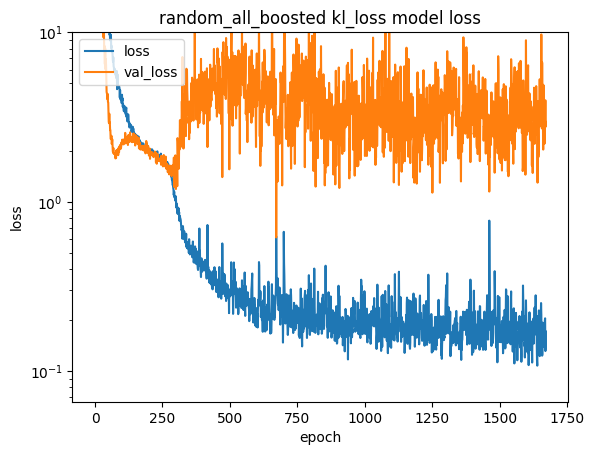

Val loss: 0.6142240762710571
Train loss: 0.6227149367332458
Test loss: 0.7608699798583984
dO18 RMSE: 0.781159656126665
EXPECTED:
    d18O_cel_mean  d18O_cel_variance
0          26.130            0.19025
1          26.984            0.40123
2          24.656            0.17728
3          26.356            0.03953
4          23.962            0.30992
5          24.848            0.15842
6          25.080            0.05125
7          26.546            2.14378
8          25.682            0.94472
9          24.028            0.45852
10         23.944            0.15813
11         23.752            0.52437
12         26.018            0.96417

PREDICTED:
    d18O_cel_mean  d18O_cel_variance
0       25.638020           0.940464
1       26.373734           1.112991
2       25.083710           1.396025
3       26.776901           0.780901
4       23.720564           2.286960
5       23.468111           2.604398
6       23.709505           2.357202
7       25.909279           6.316822
8       

2023-08-02 22:10:04.597409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [13,13]
	 [[{{node Placeholder/_0}}]]


['MyDrive/amazon_rainforest_files/variational/model/random_all_boosted_transformer.pkl']

In [40]:
grouped_random_fileset = {
    'TRAIN' : os.path.join(FP_ROOT, 'amazon_sample_data/kriging_ensemble_experiment/uc_davis_train_random_grouped.csv'),
    'TEST' : os.path.join(FP_ROOT, 'amazon_sample_data/kriging_ensemble_experiment/uc_davis_test_random_grouped.csv'),
    'VALIDATION' : os.path.join(FP_ROOT, 'amazon_sample_data/kriging_ensemble_experiment/uc_davis_validation_random_grouped.csv'),
}

columns_to_normalize = []
columns_to_standardize = [
    'lat', 'long', 'VPD', 'RH', 'PET', 'DEM', 'PA',
    'Mean Annual Temperature', 'Mean Annual Precipitation']

data = load_and_scale(grouped_random_fileset, columns_to_normalize, columns_to_standardize)
model = train_and_evaluate(data, "random_all_boosted", training_batch_size=3)
model.save(get_model_save_location("random_all_boosted.keras"))
dump(data.feature_scaler, get_model_save_location('random_all_boosted_transformer.pkl'))


### 2) Grouped, random, ablating other models except kriging

We can generate isoscapes for this model easily.

         lat       long      VPD       RH       PET  DEM          PA  \
0  -0.121000 -67.013000  0.58917  0.83284  91.16666  101  1000.89270   
1  -0.041000 -66.872000  0.62083  0.82559  92.27500   93  1001.84741   
2  -3.995545 -57.589273  0.85167  0.77358  99.99167   61  1005.67358   
3  -0.121230 -67.013103  0.58917  0.83284  91.16666  101  1000.89270   
4  -3.992300 -54.908000  0.70750  0.80339  97.88333  108  1000.05792   
..       ...        ...      ...      ...       ...  ...         ...   
94 -2.496000 -59.120000  0.77500  0.78866  98.45000  139   996.36792   
95 -2.493000 -59.121000  0.77500  0.78866  98.45000  139   996.36792   
96 -3.907183 -66.055146  0.64000  0.82437  89.98333   88  1002.44446   
98 -2.497000 -59.121000  0.77500  0.78866  98.45000  139   996.36792   
99 -2.483000 -59.124000  0.77500  0.78866  98.45000   96  1001.48932   

    Mean Annual Temperature  Mean Annual Precipitation  krig_mean_residual  \
0                  26.20833                       2830   

/tmp/ipykernel_1912349/3424320398.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 10))


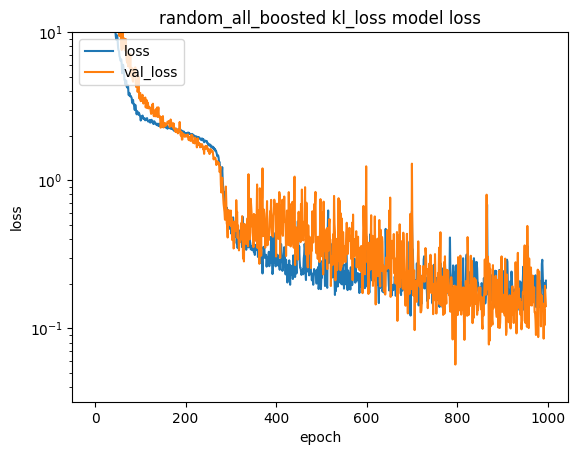

Val loss: 0.056783467531204224
Train loss: 0.18755559623241425
Test loss: 0.1438456028699875
dO18 RMSE: 0.2464965241797656
EXPECTED:
    d18O_cel_mean  d18O_cel_variance
0          26.130            0.19025
1          26.984            0.40123
2          24.656            0.17728
3          26.356            0.03953
4          23.962            0.30992
5          24.848            0.15842
6          25.080            0.05125
7          26.546            2.14378
8          25.682            0.94472
9          24.028            0.45852
10         23.944            0.15813
11         23.752            0.52437
12         26.018            0.96417

PREDICTED:
    d18O_cel_mean  d18O_cel_variance
0       26.159655           0.357570
1       27.060946           0.498601
2       24.464302           0.311572
3       26.079882           0.274227
4       23.860586           0.474837
5       24.961367           0.199061
6       25.182415           0.133716
7       26.983627           4.187814
8   

2023-08-02 22:15:02.547774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [13,11]
	 [[{{node Placeholder/_0}}]]


['/usr/local/google/home/ruru/Downloads/model_builds/random_all_boosted_transformer.pkl']

In [46]:
grouped_random_fileset = {
    'TRAIN' : os.path.join(FP_ROOT, 'amazon_sample_data/kriging_ensemble_experiment/uc_davis_train_random_grouped.csv'),
    'TEST' : os.path.join(FP_ROOT, 'amazon_sample_data/kriging_ensemble_experiment/uc_davis_test_random_grouped.csv'),
    'VALIDATION' : os.path.join(FP_ROOT, 'amazon_sample_data/kriging_ensemble_experiment/uc_davis_validation_random_grouped.csv'),
}

columns_to_normalize = []
columns_to_standardize = [
    'lat', 'long', 'VPD', 'RH', 'PET', 'DEM', 'PA',
    'Mean Annual Temperature', 'Mean Annual Precipitation']

data = load_and_scale(grouped_random_fileset, columns_to_normalize, columns_to_standardize)
model = train_and_evaluate(data, "random_ablated_boosted", training_batch_size=3)
model.save(get_model_save_location("random_ablated_boosted.keras"))
dump(data.feature_scaler, get_model_save_location('random_ablated_boosted_transformer.pkl'))

### 3) Grouped, fixed, all columns

We can't (easily) generate isoscapes with these because the isoscapes for 'predkrig_br_lat_ISORG', 'Iso_Oxi_Stack_mean_TERZER',
                   'isoscape_fullmodel_d18O_prec_REGRESSION' are not easily retrievable... but I'm curious how much better the model is if these columns are included.

grouped_fixed_all
Model: "model_51"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_56 (InputLayer)          [(None, 14)]         0           []                               
                                                                                                  
 tf.__operators__.getitem_123 (  (None, 12)          0           ['input_56[0][0]']               
 SlicingOpLambda)                                                                                 
                                                                                                  
 dense_102 (Dense)              (None, 20)           260         ['tf.__operators__.getitem_123[0]
                                                                 [0]']                            
                                                                         

/tmp/ipykernel_3673974/1016735986.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 10))


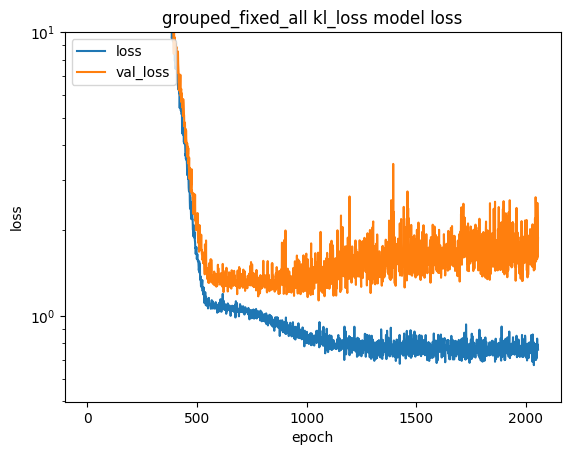

Val loss: 1.133312702178955
Train loss: 0.8401697278022766
Test loss: 4.44401216506958
dO18 RMSE: 4.1899053785054035
EXPECTED:
    d18O_cel_mean  d18O_cel_variance
0       24.042000           0.345970
1       25.240000           0.035950
2       25.782000           0.372220
3       25.076000           0.230280
4       25.966000           0.172480
5       27.434000           0.501030
6       28.156000           0.999030
7       26.836000           0.120880
8       28.180000           0.778250
9       26.834000           0.094930
10      26.644000           0.488430
11      26.772000           0.373370
12      27.684280           1.216389
13      27.403235           0.892280
14      24.777670           0.736571
15      25.551850           0.312355
16      25.115885           0.033519
17      25.987815           5.280825
18      24.132031           0.389042
19      24.898000           0.236070
20      23.944000           0.158130
21      26.018000           0.964170

PREDICTED:
    d18O_c

2023-08-01 22:20:57.439759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [22,14]
	 [[{{node Placeholder/_0}}]]


In [ ]:
grouped_fixed_fileset = {
    'TRAIN' : os.path.join(FP_ROOT, 'amazon_sample_data/kriging_ensemble_experiment/uc_davis_train_fixed_grouped.csv'),
    'TEST' : os.path.join(FP_ROOT, 'amazon_sample_data/kriging_ensemble_experiment/uc_davis_test_fixed_grouped.csv'),
    'VALIDATION' : os.path.join(FP_ROOT, 'amazon_sample_data/kriging_ensemble_experiment/uc_davis_validation_fixed_grouped.csv'),
}


columns_to_keep = ['d18O_cel_mean', 'd18O_cel_variance',
                   'lat', 'long', 'VPD', 'RH', 'PET', 'DEM', 'PA',
                   'Mean Annual Temperature','Mean Annual Precipitation',
                   'predkrig_br_lat_ISORG', 'Iso_Oxi_Stack_mean_TERZER',
                   'isoscape_fullmodel_d18O_prec_REGRESSION',
                   'ordinary_kriging_linear_d18O_predicted_mean'
                   'ordinary_kriging_linear_d18O_predicted_variance']

data = load_and_scale(grouped_fixed_fileset, columns_to_keep)
model = train_and_evaluate(data, "grouped_fixed_all", training_batch_size=3)

## 4) Grouped fixed, ablating other columns besides krigin

grouped_fixed_ablated
Model: "model_52"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_57 (InputLayer)          [(None, 11)]         0           []                               
                                                                                                  
 tf.__operators__.getitem_126 (  (None, 9)           0           ['input_57[0][0]']               
 SlicingOpLambda)                                                                                 
                                                                                                  
 dense_104 (Dense)              (None, 20)           200         ['tf.__operators__.getitem_126[0]
                                                                 [0]']                            
                                                                     

/tmp/ipykernel_3673974/1016735986.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 10))


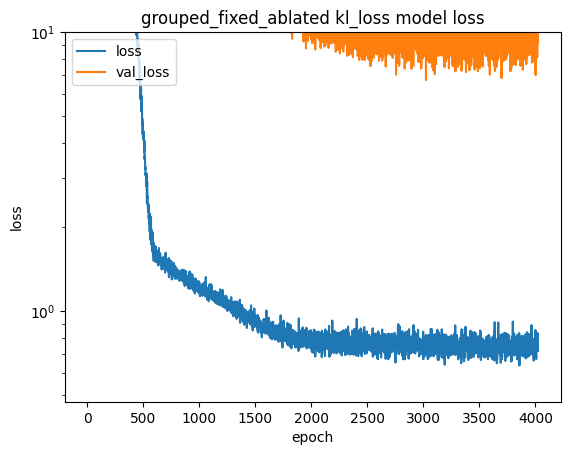

Val loss: 6.73103666305542
Train loss: 0.8037930130958557
Test loss: 19.681373596191406
dO18 RMSE: 7.362366926203444
EXPECTED:
    d18O_cel_mean  d18O_cel_variance
0       24.042000           0.345970
1       25.240000           0.035950
2       25.782000           0.372220
3       25.076000           0.230280
4       25.966000           0.172480
5       27.434000           0.501030
6       28.156000           0.999030
7       26.836000           0.120880
8       28.180000           0.778250
9       26.834000           0.094930
10      26.644000           0.488430
11      26.772000           0.373370
12      27.684280           1.216389
13      27.403235           0.892280
14      24.777670           0.736571
15      25.551850           0.312355
16      25.115885           0.033519
17      25.987815           5.280825
18      24.132031           0.389042
19      24.898000           0.236070
20      23.944000           0.158130
21      26.018000           0.964170

PREDICTED:
    d18O_c

2023-08-01 22:24:26.463319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [22,11]
	 [[{{node Placeholder/_0}}]]


In [ ]:
grouped_fixed_fileset = {
    'TRAIN' : os.path.join(FP_ROOT, 'amazon_sample_data/kriging_ensemble_experiment/uc_davis_train_fixed_grouped.csv'),
    'TEST' : os.path.join(FP_ROOT, 'amazon_sample_data/kriging_ensemble_experiment/uc_davis_test_fixed_grouped.csv'),
    'VALIDATION' : os.path.join(FP_ROOT, 'amazon_sample_data/kriging_ensemble_experiment/uc_davis_validation_fixed_grouped.csv'),
}


columns_to_keep = ['d18O_cel_mean', 'd18O_cel_variance',
                   'lat', 'long', 'VPD', 'RH', 'PET', 'DEM', 'PA',
                   'Mean Annual Temperature','Mean Annual Precipitation',
                   'ordinary_kriging_linear_d18O_predicted_mean'
                   'ordinary_kriging_linear_d18O_predicted_variance']

data = load_and_scale(grouped_fixed_fileset, columns_to_keep)
model = train_and_evaluate(data, "grouped_fixed_ablated", training_batch_size=3)